# Project 5

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string # contains punctuation to remove
from cleantext import clean # contains emojis to remove
import re # used for working with string data
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') # Needed for lemmatization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import operator

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\twjos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The data for this project came from Kaggle. It contains The qualitative ratings and numerical ratings for books on the Goodreads website, as well as other variables (such as the number of votes and comments the rating text recieved). 

In [2]:
# import data 
goodreads = pd.read_csv("data/goodreads_train.csv")

In [3]:
goodreads.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


### General Preprocessing

In [4]:
# Look at how much data we have
print(f"The dataset has {len(goodreads)} samples.")

The dataset has 900000 samples.


We really don't need that much data for the purpose of this project. We should cut it down. Let's look at other factors before deciding how much to cut.

In [5]:
# Descriptive stats for the numerical variables
goodreads.describe()

,book_id,rating,n_votes,n_comments
count,9.000000e+05,900000.000000,900000.000000,900000.000000
mean,1.344145e+07,3.689639,3.294381,1.016656
std,9.357863e+06,1.252583,17.873553,5.963821
min,1.000000e+00,0.000000,-3.000000,-1.000000
25%,6.340471e+06,3.000000,0.000000,0.000000
50%,1.344203e+07,4.000000,0.000000,0.000000
75%,2.057897e+07,5.000000,2.000000,0.000000
max,3.632868e+07,5.000000,3222.000000,1335.000000


It really doesn't look like there are that many votes or comments, let's drop those and just use the text to make things easier. We also don't need the ids and the dates. 

In [6]:
goodreads = goodreads[["review_text", "rating"]]

<AxesSubplot: xlabel='rating', ylabel='count'>

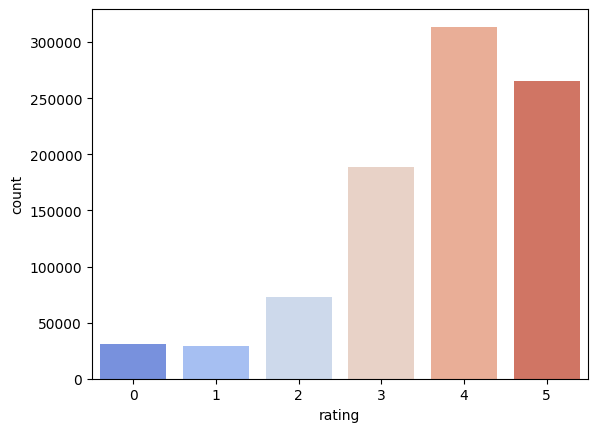

In [7]:
# It looks like the ratings are really skewed
sns.countplot(x = goodreads.rating, palette = "coolwarm")

We want to recode the ratings to a binary variable. Given the skew, let's do the following:
- **1 - 3 = 0 (not great)**  
- **4 - 5 = 1 (great)**

In [8]:
# Recode rating
not_great = [1, 2, 3]
great = [4, 5]

conditions = [goodreads.rating.isin(not_great), goodreads.rating.isin(great)]
values = [0, 1]


goodreads["rating"]  = np.select(conditions, values)

<AxesSubplot: xlabel='rating', ylabel='count'>

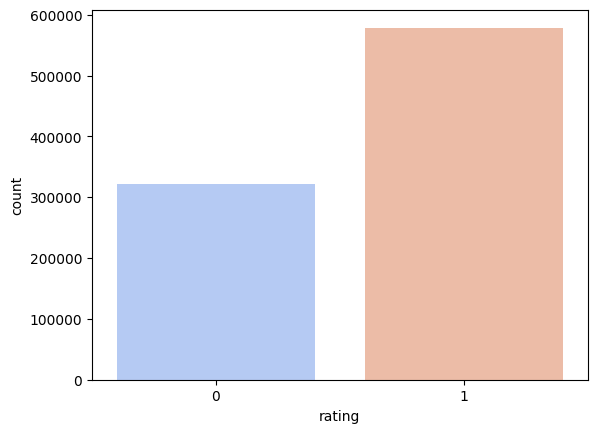

In [9]:
sns.countplot(x = goodreads.rating, palette = "coolwarm")

This is still a lot of data. The text preprocessing is going to take forever. Let's take a sample of 5,000 of each rating (so 10,000 total).

In [10]:
goodreads = goodreads.groupby("rating").sample(5000, random_state = 10).reset_index(drop = True)

In [11]:
goodreads.rating.value_counts()

0    5000
1    5000
Name: rating, dtype: int64

### Text Cleaning

In [12]:
# Create a function to clean the review text
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    cleaned_text = text.lower() # Make everything lowercase
    cleaned_text = "".join(char for char in cleaned_text if char not in string.punctuation) # Remove punctuation
    cleaned_text = re.sub(r"http\S+", "", cleaned_text) # remove URLs from the review
    cleaned_text = re.sub("\n", "", cleaned_text) # I noticed multiple reviews had  the new line symbol (see below cell), so remove those
    cleaned_text = re.sub('  ', ' ', cleaned_text) # remove extra spaces (if any)
    cleaned_text = cleaned_text.split(' ') # Temporarily tokenize for stopword removal and lemmatization
    
    # The following line of code does a couple things:
    ### 1: Removes the word if it is a stopword (e.g., common word that will not be useful, like "the")
    ### 2: Lemmazizes the word (e.g., convert to base form so similar words are not counted as separate words)
    cleaned_text = [lemmatizer.lemmatize(word) for word in cleaned_text if word not in stop_words]
    cleaned_text = ' '.join(cleaned_text) # get back to a string
       
    return cleaned_text

In [13]:
# Clean the text in each review
goodreads.review_text = goodreads.review_text.apply(lambda review: clean_text(review))
# Check first 5 reviews
goodreads.review_text.head()

0      didnt like book much hoped still pretty awesome
1    untouched lot creepy exactly alone waiting sou...
2    16th birthday alice family attend little siste...
3    read passage grade 11 english class wanting re...
4    ive wanted say already said review yay mine su...
Name: review_text, dtype: object

### Train/Test Split and Bag of Words
Split the data, create a bag of words from the training data.

In [14]:
train, test = train_test_split(goodreads, random_state = 10)

In [15]:
# Separate predictors and outcomes
X_train = train.review_text.to_numpy()
y_train = train.rating.to_numpy()

X_test = test.review_text.to_numpy()
y_test = test.review_text.to_numpy()

In [16]:
CV = CountVectorizer(stop_words = None, max_features = 5000) # Only get the top 5000 words
CV.fit(X_train)
X_train = CV.transform(X_train)
# The training data is now a Bag of Words (a matrix of word counts)
X_train.shape

(7500, 5000)

In [17]:
# Get the top ten most frequent words in the vocabulary
vocabulary = CV.vocabulary_.items() # Get all of the words in the vocabulary
totals = X_train.sum(axis = 0) # count words
frequencies = [(word, totals[0, index]) for word, index in vocabulary] # Get the frequencies for all the words
frequencies = sorted(frequencies, key = lambda x: x[1], reverse  = True) # sort words based on the frequencies
frequencies[ : 10]

[('book', 16662),
 ('like', 7014),
 ('one', 6298),
 ('read', 6254),
 ('character', 6238),
 ('story', 6225),
 ('really', 5783),
 ('love', 4555),
 ('time', 3918),
 ('get', 3648)]

Maybe we could add book to the stopwords. I doubt it will tell us much.

In [18]:
# We use the vocabulary from the training data to transform the tokens in the test set. 
X_test = CV.transform(X_test)

### Model fit and accuracy

This is pretty much the same process as any other sklearn model. 

In [19]:
from sklearn.naive_bayes import MultinomialNB